# Dense Document Retriever - Experimento

Ranqueia textos de acordo com um outro texto de entrada através do ranqueador DPR do hugginfaces.<br>

### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [2]:
dataset = "/tmp/data/expanded_en-3.csv" #@param {type:"string"}
column_context = "expanded_context_en" #@param {type:"string",label:"Coluna do dataframe de entrada com os contextos para ranquear"}
question = "Qual é o melhor herbicida para erva da ninha ?" #@param {type:"string",label:"Pergunta para a qual os contextos devem ser ranqueados"}
top = 10 #@param {type:"integer",label:"Quantidade de contextos para retornados"}
inner_batch_size = 10 #@param {type:"integer",label:"Batch size",description:"Tamanho do batchsize interno ao DPR do hugginfaces"}
tokenizer_fn = "facebook/dpr-reader-single-nq-base" #@param ["facebook/dpr-reader-single-nq-base"] {type:"string",label:"Nome do tokenizador",description:"Nome do tokenizador na base do hugginfaces"}
tokenizer_max_len = 512 #@param {type:"integer",label:"Tamanho máximo das sentenças",description:"Tamanho máximo das sentenças do tokenizador do hugginfaces"}
dpr_fn = "facebook/dpr-reader-single-nq-base" #@param ["facebook/dpr-reader-single-nq-base"] {type:"string",label:"Nome do modelo",description:"Nome do modelo na base do hugginfaces"}
column_doc_id = "doc_id" #@param {type:"string",label:"Coluna com o ID do contexto",description:"Nome da coluna que contexto os ids dos contextos a serem ranqueados"}
column_score = "retriever_score" #@param {type:"string",label:"Coluna com o score",description:"Nome da coluna que conterá o score dos contextos ranqueados após a inferência do modelo"}

# Acesso ao conjunto de dados¶
O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.
O tipo da variável retornada depende do arquivo de origem:

* pandas.DataFrame para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
* Binary IO stream para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [3]:
import pandas as pd

df = pd.read_csv(dataset)
columns = df.columns

## Conteúdo da tarefa

In [4]:
from translator import Translate
t = Translate(input_language="Português",
                        target_language="Inglês",
                        max_length=512,
                        inference_batch_size=1,
                        seed=42)
question = t.translate([question])[0]

In [6]:
from model_dense_retriever import EnglishDPRRetriever
retriever = EnglishDPRRetriever(tokenizer_fn = tokenizer_fn,
                                dpr_fn = dpr_fn,
                                tokenizer_max_len = tokenizer_max_len)
report_contexts = list(df[column_context])
doc_ids = list(df[column_doc_id])

In [7]:
sim_contexts_ids, scores = retriever(questions=question,
                                     passages = report_contexts,
                                     doc_ids=doc_ids,
                                     inner_batch_size = inner_batch_size,
                                     top=top)

Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from aux_functions import build_result_dataframe

df_result = build_result_dataframe(df_input=df,
                            sim_contexts_ids=sim_contexts_ids[0],
                            scores=scores,
                            column_doc_id = column_doc_id,
                            column_score = column_score)

## Visualizando os resultados

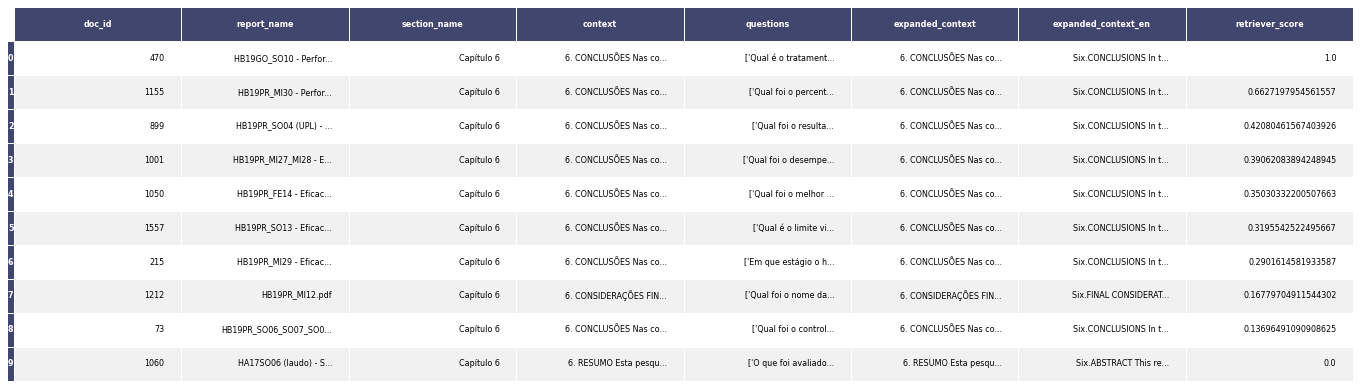

In [9]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table

ax = plot_data_table(df_result)
plt.show()

In [7]:
df_result.to_csv(dataset, index=False)

## Salva resultados da tarefa

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.<br>
Use essa pasta para salvar modelos, metadados e outros resultados.

In [10]:
from joblib import dump

artifacts = {
    "model":retriever,
    "columns":columns,
    "inner_batch_size":inner_batch_size,
    "top":top,
    "question":question,
    "column_context":column_context,
    "column_score":column_score,
    "column_doc_id":column_doc_id,
}


dump(artifacts, "/tmp/data/sparse_retriever.joblib")

['/tmp/data/sparse_retriever.joblib']